# Description

> Use the Flowers dataset and a pretrained ResNet 18 to demonstrate why initial layers are frozen during the first few epochs of transfer learning. Does your model do better or worse when you freeze the initial layers for the first few epochs?

## flowers

* main http://www.robots.ox.ac.uk/~vgg/data/flowers/102/
* tutorial None
* download 	https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
* SOTA https://paperswithcode.com/sota/fine-grained-image-classification-on-oxford

## Resnet 18

* main https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet18
* tutorial https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
!pip freeze | grep -v fastai | wc -l | grep -w "0" && pip install fastai

In [2]:
from fastai.vision.all import *

In [3]:
path=untar_data('https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz')

In [4]:
path.ls()

(#5) [Path('/home/tyoc213/.fastai/data/oxford-102-flowers/test.txt'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/models'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/train.txt'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/valid.txt')]

In [5]:
p0,p2,p3 = path.ls()[0], path.ls()[2], path.ls()[3]
!echo "test" && tail $p0 && cat $p0 | wc -l
!echo "train" && tail $p2 && cat $p2 | wc -l
!echo "valid" && tail $p3 && cat $p3 | wc -l
(path/'jpg').ls()

test
jpg/image_00985.jpg 45
jpg/image_06412.jpg 8
jpg/image_07145.jpg 44
jpg/image_00638.jpg 88
jpg/image_07558.jpg 94
jpg/image_08168.jpg 61
jpg/image_07487.jpg 94
jpg/image_04432.jpg 89
jpg/image_02532.jpg 75
jpg/image_00178.jpg 76
6149
train
tail: error reading '/home/tyoc213/.fastai/data/oxford-102-flowers/models': Is a directory
valid
jpg/image_04045.jpg 11
jpg/image_06142.jpg 63
jpg/image_07082.jpg 66
jpg/image_03345.jpg 7
jpg/image_07587.jpg 94
jpg/image_02944.jpg 59
jpg/image_07434.jpg 93
jpg/image_02684.jpg 57
jpg/image_01639.jpg 81
jpg/image_03165.jpg 10
1020


(#8189) [Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_04376.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_01488.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_01097.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07466.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_06858.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_05681.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07165.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_05913.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_02539.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07056.jpg')...]

In [6]:
df_train = pd.read_csv(path/'train.txt', header=0,sep=" ", names=['img', 'label'])
df_train['is_valid'] = False
df_valid = pd.read_csv(path/'valid.txt', header=0,sep=" ", names=['img', 'label'])
df_valid['is_valid'] = True
df = pd.concat([df_train, df_valid])
df.head(), df.tail()

(                   img  label  is_valid
 0  jpg/image_06092.jpg     13     False
 1  jpg/image_02400.jpg     42     False
 2  jpg/image_02852.jpg     55     False
 3  jpg/image_07710.jpg     96     False
 4  jpg/image_07191.jpg      5     False,
                       img  label  is_valid
 1014  jpg/image_08182.jpg     61      True
 1015  jpg/image_07029.jpg     38      True
 1016  jpg/image_05956.jpg     67      True
 1017  jpg/image_06051.jpg     13      True
 1018  jpg/image_07724.jpg     96      True)

In [7]:
dls = ImageDataLoaders.from_df(df, path, valid_col='is_valid',
                               bs=64,
                               item_tfms=Resize(320)
                              )

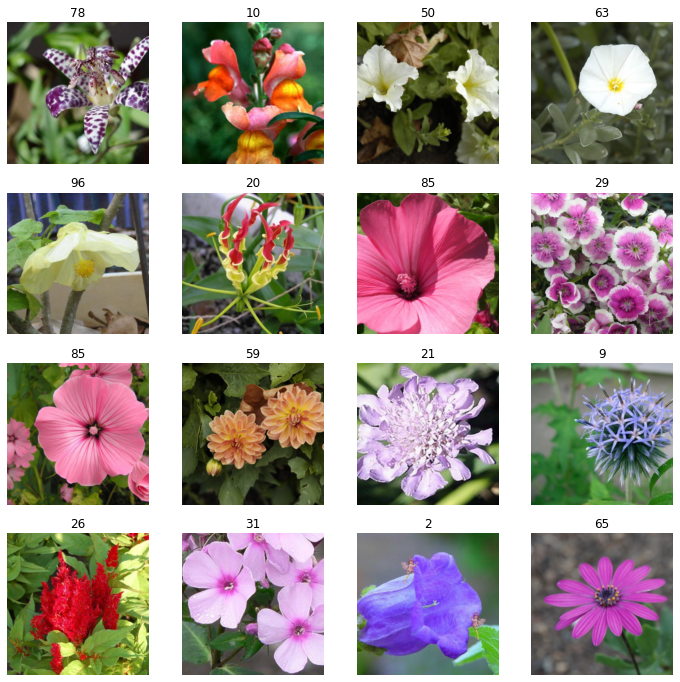

In [8]:
dls.show_batch(max_n=16)

## used vars and methods

In [9]:
MODELO=resnet18
MIN_EPOCHS=3

@patch_to(Learner)
def print_trainable_count(self):
    linfo = [(o[1], o[2]) for o in layer_info(learn, learn.dls.one_batch()[0]) if o is not None and o[3] is not None and o[1] is not '']
    total,trainable=0,0
    for c, t in linfo:
        total += c
        if t: trainable += c
    print(f'Trainable {trainable:,}, not trainable {total-trainable:,}. Total params: {total:,}')

<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-9-a45d3190f817>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  linfo = [(o[1], o[2]) for o in layer_info(learn, learn.dls.one_batch()[0]) if o is not None and o[3] is not None and o[1] is not '']


## use the preferred learning rate

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.010964781977236271)

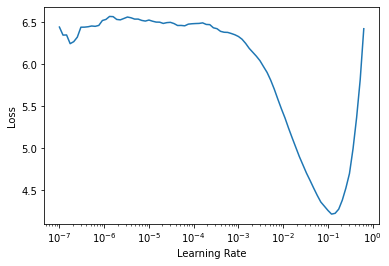

In [10]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.lr_find()

## first unfreeze and train

In [11]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.209214,3576.129883,0.990186,0.009814,00:08
1,5.833638,42.924023,0.982336,0.017664,00:08
2,5.519739,13.576124,0.950932,0.049068,00:07
3,5.279107,10.601151,0.957802,0.042198,00:07
4,5.108163,13.240731,0.945044,0.054956,00:08
5,4.882128,7.044961,0.937193,0.062807,00:08


## normal call

In [12]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.873168,4.137469,0.710500,0.289500,00:07
1,2.270839,1.591137,0.399411,0.600589,00:07
2,1.485604,1.053990,0.268891,0.731109,00:08
3,1.044750,0.862981,0.226693,0.773307,00:08
4,0.768266,1.052933,0.250245,0.749755,00:07
5,0.590197,0.800770,0.202159,0.797841,00:07


## freeze first, then unfreeze and freeze again

In [13]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.freeze_to(-1)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.752481,4.604897,0.727184,0.272816,00:07
1,2.180768,1.515095,0.363101,0.636899,00:07
2,1.428915,1.076359,0.265947,0.734053,00:07
3,1.001166,0.798617,0.211973,0.788027,00:07
4,0.747544,0.838258,0.216879,0.783121,00:07
5,0.579925,0.852672,0.216879,0.783121,00:07


In [14]:
learn.freeze_to(-2)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS,lr=0.01)

Trainable 11,074,944, not trainable 681,152. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.334148,422.826447,0.990186,0.009814,00:07
1,5.389382,15.629828,0.956820,0.043180,00:07
2,4.590200,4.233865,0.838077,0.161923,00:07


In [16]:
learn.freeze_to(-3)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS,lr=0.01)

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.200259,2637.012939,0.990186,0.009814,00:08
1,6.036861,181.334030,0.986261,0.013739,00:07
2,5.782084,6.909907,0.963690,0.036310,00:07


## groups of the model

When fastai downloads resnet it happens a head which is trainable which is `learn.model[1]`, so we focus on `learn.model[1]`

In [20]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [38]:
type(learn.model), type(learn.model[0]), type(learn.model[0][0]), type(learn.model[0][7]), type(learn.model[0][7][0])

(torch.nn.modules.container.Sequential,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.container.Sequential,
 torchvision.models.resnet.BasicBlock)

In [39]:
isinstance(learn.model, nn.Module), isinstance(learn.model[0], nn.Module), isinstance(learn.model[0][7][0], nn.Module)

(True, True, True)

In [40]:
def set_grad(module, req_grad=False):
    for p in module.parameters():
        p.requires_grad = req_grad

def count_params(module):
    train, not_train = 0,0
    for p in module.parameters():
        if p.requires_grad:
            train += 1
        else:
            not_train += 1
    return train, not_train


In [49]:
module = learn.model[0][7]
len(params(module)), '=', len(params(module[0])), '+',len(params(module[1]))

(15, '=', 9, '+', 6)

In [43]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.797355,3.888509,0.658489,0.341511,00:06
1,2.181237,1.898499,0.426889,0.573111,00:06
2,1.424278,1.070681,0.283611,0.716389,00:06


In [45]:
print('     Starting')
print(count_params(module))
learn.print_trainable_count()
print('     All True count')
set_grad(module, True)
print(count_params(module))
learn.print_trainable_count()

     Starting
(10, 5)


Trainable 598,592, not trainable 11,157,504. Total params: 11,756,096
     All True count
(15, 0)


Trainable 8,987,200, not trainable 2,768,896. Total params: 11,756,096


In [46]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.175173,81.274361,0.979392,0.020608,00:06
1,4.201419,5.872329,0.801766,0.198234,00:06
2,3.450940,3.527155,0.667321,0.332679,00:06


In [51]:
module = learn.model[0][0]
len(params(module)), '=', len(params(module))

(1, '=', 1)

In [52]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.752222,3.161222,0.617272,0.382728,00:06
1,2.200372,1.441661,0.355250,0.644750,00:06
2,1.454770,1.035136,0.277723,0.722277,00:06


In [53]:
print('     Starting')
print(count_params(module))
learn.print_trainable_count()
print('     All True count')
set_grad(module, True)
print(count_params(module))
learn.print_trainable_count()

     Starting
(1, 0)


Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096
     All True count
(1, 0)


Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


In [54]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.390502,1.137486,0.276742,0.723258,00:06
1,0.306902,0.927665,0.239450,0.760550,00:06
2,0.272834,0.779958,0.209028,0.790972,00:06


In [55]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.162663,0.769130,0.196271,0.803729,00:06
1,0.169467,1.004515,0.234544,0.765456,00:06
2,0.161173,0.944544,0.230618,0.769382,00:06


In [56]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.747494,5.338952,0.745829,0.254171,00:06
1,2.218046,1.806927,0.411187,0.588813,00:06
2,1.475183,1.130612,0.280667,0.719333,00:06


In [57]:
set_grad(module, True)

In [58]:
learn.fit(4, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.361498,0.857587,0.199215,0.800785,00:06
1,0.285121,0.817325,0.194308,0.805692,00:06
2,0.262234,1.023641,0.235525,0.764475,00:06
3,0.236817,0.859693,0.196271,0.803729,00:06


In [59]:
learn.freeze_to(-1)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS, lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.463880,1.688219,0.352306,0.647694,00:06
1,0.556625,1.783953,0.350343,0.649657,00:06
2,0.486484,1.230257,0.241413,0.758587,00:06


In [60]:
learn.fit(MIN_EPOCHS*3, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.275009,0.970085,0.201178,0.798822,00:06
1,0.260896,1.111422,0.240432,0.759568,00:06
2,0.236401,1.565528,0.272816,0.727184,00:06
3,0.225192,0.905659,0.186457,0.813543,00:06
4,0.257428,1.245333,0.246320,0.753680,00:06
5,0.274041,1.491646,0.267910,0.732090,00:06
6,0.272034,1.006605,0.193327,0.806673,00:06
7,0.285982,1.425780,0.244357,0.755643,00:06
8,0.264988,1.112279,0.205103,0.794897,00:06


In [61]:
learn.fit(MIN_EPOCHS*10, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.228841,1.205071,0.217861,0.782139,00:06
1,0.231447,1.758239,0.273798,0.726202,00:06
2,0.246255,1.233360,0.219823,0.780177,00:06
3,0.233931,1.376822,0.256133,0.743867,00:06
4,0.199979,1.370563,0.240432,0.759568,00:06
5,0.181063,1.284255,0.226693,0.773307,00:06
6,0.174841,1.330204,0.215898,0.784102,00:06
7,0.164545,1.185934,0.198234,0.801766,00:06
8,0.168630,1.332948,0.219823,0.780177,00:06
9,0.172340,1.299900,0.210991,0.789009,00:06


In [69]:
learn.model[0][7][0].conv1.weight.shape, learn.model[0][7][1].conv1.weight.shape

(torch.Size([512, 256, 3, 3]), torch.Size([512, 512, 3, 3]))

In [70]:
512*256*3*3 + 512*512*3*3

3538944

In [74]:
589184 - 8977792

-8388608

In [75]:
8388608-3538944

4849664